## Calculate water transports and save in files


This notebook calculates the water transport through several cross sections along the shelf, across the shelf and vertically, from canyon to shelf. See plot below. Transport is calculated as $u_i * a_i$, with units m3/s and each transport xarray dataset is stored in a file according to its orientation:

* run##water_CS_transports.nc - cross-shelf and vertical transports

There is one of each files for every run.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import xarray as xr

In [2]:
# Define slices and positions of cross sections 
CS1_x_slice = slice(0, 60)
CS2_x_slice = slice(60, 120)
CS3_x_slice = slice(120, 240)
CS4_x_slice = slice(240, 300)
CS5_x_slice = slice(300, 360)
CS6_x_slice = slice(360, 616)
CSCOAST_x_slice = slice(0, 360)

CS_y_coast = 358
CS1_y_ind = 227

/home/kramosmu/anaconda3/lib/python3.5/site-packages/matplotlib/contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


Text(0,0.5,'depth [m]')

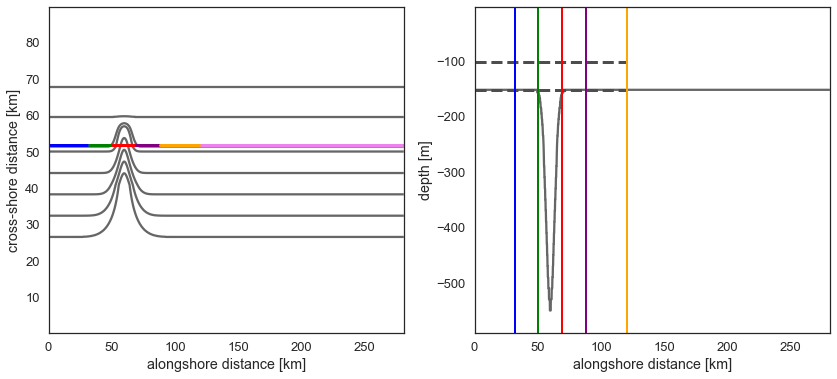

In [3]:
grid_file = '/data/kramosmu/results/TracerExperiments/CNTDIFF/run38/gridGlob.nc'
grid = xr.open_dataset(grid_file)

sns.set_style(style='white')
sns.set_context('talk')
fig, ax = plt.subplots(1, 2, figsize=(14,6))

ax[0].contour(grid.X/1000,grid.Y/1000,grid.Depth,[50,100,150,200,400,600,800,1000], colors='0.4')

ax[0].plot(grid.XC[CS1_y_ind,CS1_x_slice]/1000,grid.YC[CS1_y_ind,CS1_x_slice]/1000, 'b-', linewidth=3)
ax[0].plot(grid.XC[CS1_y_ind,CS2_x_slice]/1000,grid.YC[CS1_y_ind,CS2_x_slice]/1000, 'g-', linewidth=3)
ax[0].plot(grid.XC[CS1_y_ind,CS3_x_slice]/1000,grid.YC[CS1_y_ind,CS3_x_slice]/1000, 'r-', linewidth=3)
ax[0].plot(grid.XC[CS1_y_ind,CS4_x_slice]/1000,grid.YC[CS1_y_ind,CS4_x_slice]/1000, '-',color='purple', linewidth=3)
ax[0].plot(grid.XC[CS1_y_ind,CS5_x_slice]/1000,grid.YC[CS1_y_ind,CS5_x_slice]/1000, '-', color='orange', linewidth=3)
ax[0].plot(grid.XC[CS1_y_ind,CS6_x_slice]/1000,grid.YC[CS1_y_ind,CS6_x_slice]/1000, '-', color='violet', linewidth=3)


ax[0].set_xlabel('alongshore distance [km]')
ax[0].set_ylabel('cross-shore distance [km]')

ax[1].contour(grid.XC[227,:]/1000,grid.RC[:60],grid.HFacC[:60,227,:],[0],colors='0.4')
ax[1].plot([grid.X[0]/1000,grid.X[359]/1000],[grid.RC[20],grid.RC[20]], '--', color='0.3', linewidth=3)
ax[1].plot([grid.X[0]/1000,grid.X[359]/1000],[grid.RC[30],grid.RC[30]], '--', color='0.3', linewidth=3)

ax[1].axvline(x=grid.X[60]/1000,color='b', linewidth=2)
ax[1].axvline(x=grid.X[120]/1000,color='g', linewidth=2)
ax[1].axvline(x=grid.X[240]/1000,color='r', linewidth=2)
ax[1].axvline(x=grid.X[300]/1000,color='purple', linewidth=2)
ax[1].axvline(x=grid.X[360]/1000,color='orange', linewidth=2)


ax[1].set_xlabel('alongshore distance [km]')
ax[1].set_ylabel('depth [m]')


In [4]:
def calc_wat_transport_CS(vel_component, x_slice, y_slice, spacing, zspacing,hfac, dim_name,zini=0,zfin=30):
    '''
    INPUT:
    vel_component: xarray, Velocity component perpendicular to cross section (e.g. unstagger_xarray(state03.V,'Yp1'))
    x_slice : slice or index of cross-section in alongshore direction
    y_slice : slice or index of cross-section in cross-shore direction
    spacing: xarray, width of cross section elements (e.g. dxG, etc)
    zspacing: xarray, vertical width of vertical levels between faces (drF).
    hfac: fraction of open cell at southern cell face (HFacS variable)
    dim_name: str, name of the dimension along which to sum.
    
    '''
    vel_CS = (vel_component.isel(Yp1=y_slice, X=x_slice))
    dx_CS = (spacing.isel(Yp1=y_slice, X=x_slice))
    hfacS = hfac.isel(Yp1=y_slice,X=x_slice)

    waterCS_flux = (((dx_CS*vel_CS*hfacS).sum(dim=dim_name))*zspacing).isel(Z=slice(zini,zfin)).sum(dim='Z')

    return waterCS_flux


def unstagger_xarray(qty, index):
    """Interpolate u, v, or w component values to values at grid cell centres.
    
    Named indexing requires that input arrays are XArray DataArrays.

    :arg qty: u, v, or w component values
    :type qty: :py:class:`xarray.DataArray`
    
    :arg index: index name along which to centre
        (generally one of 'gridX', 'gridY', or 'depth')
    :type index: str

    :returns qty: u, v, or w component values at grid cell centres
    :rtype: :py:class:`xarray.DataArray`
    """
    
    qty = (qty + qty.shift(**{index: 1})) / 2
    
    return qty
    

In [11]:
#set up paths and files
grid_Can_file = '/data/kramosmu/results/TracerExperiments/CNTDIFF/run38/gridGlob.nc'
grid_NoC_file = '/data/kramosmu/results/TracerExperiments/CNTDIFF/run68/gridGlob.nc'


In [12]:
import os
import sys
lib_path = os.path.abspath('../PythonScripts/Paper1Figures/') # Add absolute path to my python scripts
sys.path.append(lib_path)

import canyon_records 
import nocanyon_records

In [13]:
records = canyon_records.main()
recordsNoC = nocanyon_records.main()

In [14]:
ii=0
for rec in records:
    print(ii,rec.name)
    ii=ii+1

0 CNTDIFF_run38
1 CNTDIFF_run37
2 CNTDIFF_run36
3 CNTDIFF_run45
4 CNTDIFF_run73
5 CNTDIFF_run75
6 CNTDIFF_run79
7 CNTDIFF_run67
8 CNTDIFF_run51
9 CNTDIFF_run69
10 CNTDIFF_run71
11 3DVISC_run01
12 3DVISC_run02
13 3DVISC_run04
14 3DVISC_run03
15 3DVISC_run05
16 3DVISC_run06
17 LOWER_BF_run01
18 LOW_BF_run01
19 LOWEST_BF_run01
20 LOWEST_BF_run03
21 LOWEST_BF_run05
22 LOWEST_BF_run07
23 LOWEST_BF_run11
24 3DVISC_REALISTIC_run01
25 3DVISC_REALISTIC_run02
26 3DVISC_REALISTIC_run03
27 3DVISC_REALISTIC_run05
28 3DVISC_REALISTIC_run06
29 3DVISC_REALISTIC_run07
30 3DVISC_REALISTIC_run08
31 3DVISC_REALISTIC_run09
32 3DVISC_REALISTIC_run10
33 3DVISC_REALISTIC_run11
34 3DVISC_REALISTIC_run12
35 3DVISC_REALISTIC_run13
36 3DVISC_REALISTIC_run14
37 3DVISC_REALISTIC_run15
38 3DVISC_REALISTIC_run16
39 3DVISC_REALISTIC_run17
40 3DVISC_REALISTIC_run18
41 3DVISC_REALISTIC_run19
42 3DVISC_REALISTIC_run20
43 3DVISC_REALISTIC_run21
44 3DVISC_REALISTIC_run22
45 3DVISC_REALISTIC_run23
46 3DVISC_REALISTIC_run24


In [15]:
records_sel = [29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,6]
recordsNoC_sel = [51,6]

In [16]:
# Save water transport canyon runs

grid = xr.open_dataset(grid_Can_file)
gridNoC = xr.open_dataset(grid_NoC_file)

ii = 0

#for ii in records_sel:
for ii in records_sel:    
    rec = records[ii]    
    
    filename=('/data/kramosmu/results/TracerExperiments/%s/%s/stateGlob.nc' %(rec.exp_code,rec.run_num))
    state = xr.open_dataset(filename)
    
    waterCS1_flux = calc_wat_transport_CS(unstagger_xarray(state.V,'Yp1'), CS1_x_slice, CS1_y_ind,
                                          unstagger_xarray(grid.dxG, 'Yp1'), grid.drF, gridNoC.HFacS, 'X')
    waterCS2_flux = calc_wat_transport_CS(unstagger_xarray(state.V,'Yp1'), CS2_x_slice, CS1_y_ind,
                                          unstagger_xarray(grid.dxG, 'Yp1'), grid.drF , gridNoC.HFacS, 'X')
    waterCS3_flux = calc_wat_transport_CS(unstagger_xarray(state.V,'Yp1'), CS3_x_slice, CS1_y_ind,
                                          unstagger_xarray(grid.dxG, 'Yp1'), grid.drF , gridNoC.HFacS, 'X')
    waterCS3b_flux = calc_wat_transport_CS(unstagger_xarray(state.V,'Yp1'), CS3_x_slice, CS1_y_ind,
                                          unstagger_xarray(grid.dxG, 'Yp1'), grid.drF , gridNoC.HFacS, 'X',zini=30,zfin=90)
    
    waterCS4_flux = calc_wat_transport_CS(unstagger_xarray(state.V,'Yp1'), CS4_x_slice, CS1_y_ind,
                                          unstagger_xarray(grid.dxG, 'Yp1'), grid.drF , gridNoC.HFacS, 'X')
    waterCS5_flux = calc_wat_transport_CS(unstagger_xarray(state.V,'Yp1'), CS5_x_slice, CS1_y_ind,
                                          unstagger_xarray(grid.dxG, 'Yp1'), grid.drF , gridNoC.HFacS, 'X')
    waterCS6_flux = calc_wat_transport_CS(unstagger_xarray(state.V,'Yp1'), CS6_x_slice, CS1_y_ind,
                                          unstagger_xarray(grid.dxG, 'Yp1'), grid.drF , gridNoC.HFacS, 'X')
    
    vel_vert = (unstagger_xarray(state.W,'Zl').isel(Zl=29,Y=slice(227,267), X=slice(120,240)))
    area = (grid.rA.isel(Y=slice(227,267), X=slice(120,240)))

    waterVert_flux = (vel_vert*area).sum(dim='Y').sum(dim='X')
    waterVert_flux.name = 'Vert_water_trans_sb'
    waterVert_flux.attrs['units'] = 'm3/s'

    waterCS1_flux.name = 'CS1_water_trans'
    waterCS1_flux.attrs['units'] = 'm3/s'
    waterCS2_flux.name = 'CS2_water_trans'
    waterCS2_flux.attrs['units'] = 'm3/s'
    waterCS3_flux.name = 'CS3_water_trans'
    waterCS3_flux.attrs['units'] = 'm3/s'
    waterCS3b_flux.name = 'CS3b_water_trans'
    waterCS3_flux.attrs['units'] = 'm3/s'
    waterCS4_flux.name = 'CS4_water_trans'
    waterCS4_flux.attrs['units'] = 'm3/s'
    waterCS5_flux.name = 'CS5_water_trans'
    waterCS5_flux.attrs['units'] = 'm3/s'
    waterCS6_flux.name = 'CS6_water_trans'
    waterCS6_flux.attrs['units'] = 'm3/s'
   
    objectsCS = [waterCS1_flux, waterCS2_flux,waterCS3_flux,waterCS3b_flux,waterCS4_flux,
                 waterCS5_flux,waterCS6_flux,waterVert_flux]
    
    DS_CS = xr.merge(objectsCS, compat='broadcast_equals', join='outer')
    
    DS_CS_path = (('/data/kramosmu/results/TracerExperiments/%s/%s' %(rec.exp_code,rec.run_num))+
                  'water_CS_transports.nc')
    DS_CS.to_netcdf(path=DS_CS_path, mode='w',engine='scipy')
    
    print(DS_CS_path)
    ii=ii+1
    


/data/kramosmu/results/TracerExperiments/3DVISC_REALISTIC/run07water_CS_transports.nc
/data/kramosmu/results/TracerExperiments/3DVISC_REALISTIC/run08water_CS_transports.nc
/data/kramosmu/results/TracerExperiments/3DVISC_REALISTIC/run09water_CS_transports.nc
/data/kramosmu/results/TracerExperiments/3DVISC_REALISTIC/run10water_CS_transports.nc
/data/kramosmu/results/TracerExperiments/3DVISC_REALISTIC/run11water_CS_transports.nc
/data/kramosmu/results/TracerExperiments/3DVISC_REALISTIC/run12water_CS_transports.nc
/data/kramosmu/results/TracerExperiments/3DVISC_REALISTIC/run13water_CS_transports.nc
/data/kramosmu/results/TracerExperiments/3DVISC_REALISTIC/run14water_CS_transports.nc
/data/kramosmu/results/TracerExperiments/3DVISC_REALISTIC/run15water_CS_transports.nc
/data/kramosmu/results/TracerExperiments/3DVISC_REALISTIC/run16water_CS_transports.nc
/data/kramosmu/results/TracerExperiments/3DVISC_REALISTIC/run17water_CS_transports.nc
/data/kramosmu/results/TracerExperiments/3DVISC_REALIS

In [17]:
print(filename)

/data/kramosmu/results/TracerExperiments/CNTDIFF/run79/stateGlob.nc


In [18]:
# Save water transport for no canyon runs

grid = xr.open_dataset(grid_NoC_file)
gridNoC = xr.open_dataset(grid_NoC_file)

ii = 0

for ii in recordsNoC_sel:
    
    rec = recordsNoC[ii]    
    
    filename=('/data/kramosmu/results/TracerExperiments/%s/%s/stateGlob.nc' %(rec.exp_code,rec.run_num))
    state = xr.open_dataset(filename)
    
    
    waterCS1_flux = calc_wat_transport_CS(unstagger_xarray(state.V,'Yp1'), CS1_x_slice, CS1_y_ind,
                                          unstagger_xarray(grid.dxG, 'Yp1'), grid.drF, gridNoC.HFacS, 'X')
    waterCS2_flux = calc_wat_transport_CS(unstagger_xarray(state.V,'Yp1'), CS2_x_slice, CS1_y_ind,
                                          unstagger_xarray(grid.dxG, 'Yp1'), grid.drF , gridNoC.HFacS, 'X')
    waterCS3_flux = calc_wat_transport_CS(unstagger_xarray(state.V,'Yp1'), CS3_x_slice, CS1_y_ind,
                                          unstagger_xarray(grid.dxG, 'Yp1'), grid.drF , gridNoC.HFacS, 'X')
    waterCS3b_flux = calc_wat_transport_CS(unstagger_xarray(state.V,'Yp1'), CS3_x_slice, CS1_y_ind,
                                          unstagger_xarray(grid.dxG, 'Yp1'), grid.drF , gridNoC.HFacS, 'X',zini=30,zfin=90)
    
    waterCS4_flux = calc_wat_transport_CS(unstagger_xarray(state.V,'Yp1'), CS4_x_slice, CS1_y_ind,
                                          unstagger_xarray(grid.dxG, 'Yp1'), grid.drF , gridNoC.HFacS, 'X')
    waterCS5_flux = calc_wat_transport_CS(unstagger_xarray(state.V,'Yp1'), CS5_x_slice, CS1_y_ind,
                                          unstagger_xarray(grid.dxG, 'Yp1'), grid.drF , gridNoC.HFacS, 'X')
    waterCS6_flux = calc_wat_transport_CS(unstagger_xarray(state.V,'Yp1'), CS6_x_slice, CS1_y_ind,
                                          unstagger_xarray(grid.dxG, 'Yp1'), grid.drF , gridNoC.HFacS, 'X')
    
    vel_vert = (unstagger_xarray(state.W,'Zl').isel(Zl=29,Y=slice(227,267), X=slice(120,240)))
    area = (grid.rA.isel(Y=slice(227,267), X=slice(120,240)))

    waterVert_flux = (vel_vert*area).sum(dim='Y').sum(dim='X')
    waterVert_flux.name = 'Vert_water_trans_sb'
    waterVert_flux.attrs['units'] = 'm3/s'

    waterCS1_flux.name = 'CS1_water_trans'
    waterCS1_flux.attrs['units'] = 'm3/s'
    waterCS2_flux.name = 'CS2_water_trans'
    waterCS2_flux.attrs['units'] = 'm3/s'
    waterCS3_flux.name = 'CS3_water_trans'
    waterCS3_flux.attrs['units'] = 'm3/s'
    waterCS3b_flux.name = 'CS3b_water_trans'
    waterCS3_flux.attrs['units'] = 'm3/s'
    waterCS4_flux.name = 'CS4_water_trans'
    waterCS4_flux.attrs['units'] = 'm3/s'
    waterCS5_flux.name = 'CS5_water_trans'
    waterCS5_flux.attrs['units'] = 'm3/s'
    waterCS6_flux.name = 'CS6_water_trans'
    waterCS6_flux.attrs['units'] = 'm3/s'
    
    objectsCS = [waterCS1_flux, waterCS2_flux,waterCS3_flux,waterCS3b_flux,waterCS4_flux,
                 waterCS5_flux,waterCS6_flux,waterVert_flux]
    
    DS_CS = xr.merge(objectsCS, compat='broadcast_equals', join='outer')
    DS_CS_path = (('/data/kramosmu/results/TracerExperiments/%s/%s' %(rec.exp_code,rec.run_num))+
                  'water_CS_transports.nc')
    DS_CS.to_netcdf(path=DS_CS_path, mode='w', engine='scipy')
    
   
    print(DS_CS_path)
    ii=ii+1
    


/data/kramosmu/results/TracerExperiments/CNTDIFF/run82water_CS_transports.nc


TypeError: unsupported operand type(s) for +: 'ellipsis' and 'int'